In [1]:
import pyemma
import pickle

import mdtraj as md
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt
import numpy as np

np.bool = np.bool_

from tqdm import tqdm
from matplotlib.colors import LogNorm


In [2]:
result_path = "../res"
molecule = "chignolin"

# Visualization

In [3]:
topology_file = f"{result_path}/{molecule}/topology.pdb"
samples_file = f"{result_path}/{molecule}/samples.xtc"

traj = md.load(samples_file, top=topology_file)
view = nv.show_mdtraj(traj)
view.add_representation("licorice", selection="protein")
view

NGLWidget(max_frame=90)

In [4]:
view.frame = 4

# TICA Plot

In [5]:
with open('tica_model.pkl', 'rb') as f:
    tica = pickle.load(f)
print(tica)

TICA(commute_map=False, dim=2, epsilon=1e-06, kinetic_map=True, lag=5,
   ncov_max=inf, reversible=True, skip=0, stride=1, var_cutoff=0.95,
   weights=None)


In [6]:
ca_atoms = traj.topology.select('name CA')
print(ca_atoms)

[ 1  5 10 15 20 25 30 34 39 44]


In [7]:
cnt = 1

for i, ca_atom in enumerate(ca_atoms):
    for j in range(i+1, len(ca_atoms)):
        print(f"d{cnt}: DISTANCE ATOMS={ca_atoms[i]}, {ca_atoms[j]}")
        cnt += 1

d1: DISTANCE ATOMS=1, 5
d2: DISTANCE ATOMS=1, 10
d3: DISTANCE ATOMS=1, 15
d4: DISTANCE ATOMS=1, 20
d5: DISTANCE ATOMS=1, 25
d6: DISTANCE ATOMS=1, 30
d7: DISTANCE ATOMS=1, 34
d8: DISTANCE ATOMS=1, 39
d9: DISTANCE ATOMS=1, 44
d10: DISTANCE ATOMS=5, 10
d11: DISTANCE ATOMS=5, 15
d12: DISTANCE ATOMS=5, 20
d13: DISTANCE ATOMS=5, 25
d14: DISTANCE ATOMS=5, 30
d15: DISTANCE ATOMS=5, 34
d16: DISTANCE ATOMS=5, 39
d17: DISTANCE ATOMS=5, 44
d18: DISTANCE ATOMS=10, 15
d19: DISTANCE ATOMS=10, 20
d20: DISTANCE ATOMS=10, 25
d21: DISTANCE ATOMS=10, 30
d22: DISTANCE ATOMS=10, 34
d23: DISTANCE ATOMS=10, 39
d24: DISTANCE ATOMS=10, 44
d25: DISTANCE ATOMS=15, 20
d26: DISTANCE ATOMS=15, 25
d27: DISTANCE ATOMS=15, 30
d28: DISTANCE ATOMS=15, 34
d29: DISTANCE ATOMS=15, 39
d30: DISTANCE ATOMS=15, 44
d31: DISTANCE ATOMS=20, 25
d32: DISTANCE ATOMS=20, 30
d33: DISTANCE ATOMS=20, 34
d34: DISTANCE ATOMS=20, 39
d35: DISTANCE ATOMS=20, 44
d36: DISTANCE ATOMS=25, 30
d37: DISTANCE ATOMS=25, 34
d38: DISTANCE ATOMS=25, 39
d

In [10]:
def compute_ca_distances(traj, ca_atoms):
	n_atoms = len(ca_atoms)	
	atom_pairs = []
	for i in tqdm(
     	range(n_atoms),
      	leave=False,
       	desc=f"Computing CA distances "
    ):
		for j in range(i+1, n_atoms):
			atom_pairs.append([ca_atoms[i], ca_atoms[j]])

	atom_pairs = np.array(atom_pairs)
	distances = md.compute_distances(traj, atom_pairs)	
	return distances

In [11]:
ca_distances = compute_ca_distances(traj, ca_atoms)
ca_distances.shape

(91, 45)

In [13]:
feat_dist = pyemma.coordinates.featurizer(topology_file)
feat_dist.add_distances(indices=ca_atoms)
feature_distances = feat_dist.transform(traj)
tica_coord = tica.transform(feature_distances)
print(tica_coord.shape)

18-06-25 01:52:15 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[1] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
(91, 2)


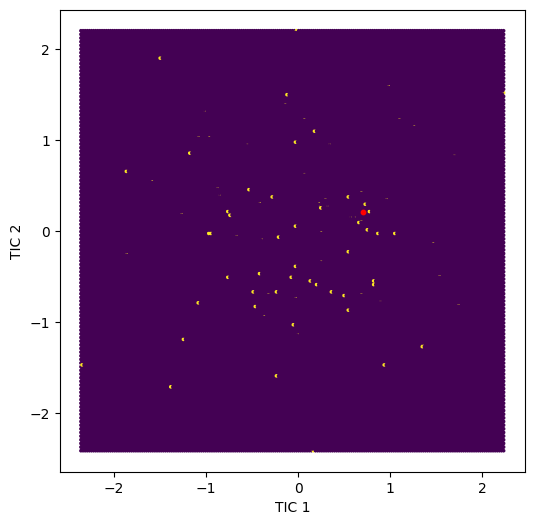

In [16]:
state_traj = md.load(topology_file)
state_feat = feat_dist.transform(state_traj)
tica_state = tica.transform(state_feat)

# Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
hb = ax.hexbin(
	tica_coord[:, 0], tica_coord[:, 1],  # data
	gridsize=200,                     # controls resolution
	reduce_C_function=np.mean,       # compute average per hexagon
	cmap='viridis',                  # colormap
)
plt.scatter(tica_state[:, 0], tica_state[:, 1], c='red', s=10)
plt.xlabel("TIC 1")
plt.ylabel("TIC 2")
plt.show()